## StatsModel

In [1]:
import requests
import json
import time
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle


In [2]:
#import needed information
# auth_df=pd.read_pickle('auth_df.pkl')
df_all=pd.read_pickle('df_all_new.pkl')

In [3]:
df_all.columns

Index(['index', 'forum', 'title', 'authors', 'keywords', 'dec', 'dec_txt',
       'dec_confidence', 'dec_title', 'bld_ratings', 'bld_text', 'bld_title',
       'year', 'clean_title', 'author_ids', 'pub_counts', 'citation_counts',
       'est_citation_counts', 'num_authors', 'affiliations',
       'pub_counts_yr_adj', 'citation_counts_yr_adj',
       'est_citation_counts_yr_adj', 'dec_sen_score', 'review_sen_score'],
      dtype='object')

In [5]:
#save to dataframe
df_all.to_csv('master_data.csv', index=False)

> ### Dataframe preprocessing

In [5]:
#take subset of dataframe for model building
df_model=df_all[['dec','year','pub_counts_yr_adj','citation_counts_yr_adj','est_citation_counts_yr_adj','num_authors','dec_sen_score','review_sen_score','affiliations']]

#remove papers without information
df_model = df_model.drop(df_model[df_model.num_authors == 0].index)

In [6]:
df_model.shape

(4842, 9)

In [7]:
#calc publicaion counts
pubcounts=df_model['pub_counts_yr_adj'].tolist()
citecounts=df_model['citation_counts_yr_adj'].tolist()
estcitecounts=df_model['est_citation_counts_yr_adj'].tolist()

pub_mean=[]
for i in pubcounts:
    total=sum(i)
    avg=total/len(i)
    pub_mean.append(avg)

cite_mean=[]
for i in citecounts:
    total=sum(i)
    avg=total/len(i)
    cite_mean.append(avg)
    
est_cite_mean=[]
for i in estcitecounts:
    total=sum(i)
    avg=total/len(i)
    est_cite_mean.append(avg)
    
#create column for average publication, and citation counts
df_model['avg_pub']=pub_mean
df_model['avg_cite']=cite_mean
df_model['avg_est_cite']=est_cite_mean

# #create column for max publication, and citation counts
df_model['max_pub']=df_model['pub_counts_yr_adj'].apply(max)
df_model['max_cite']=df_model['citation_counts_yr_adj'].apply(max)
df_model['max_est_cite']=df_model['est_citation_counts_yr_adj'].apply(max)

# #create column to differentiate between single-blind and double-blind study
df_model['type_review'] = np.where(df_model['year']==2017, 'single_blind', 'double_blind')
df_model=df_model.drop(columns=['year'])


In [8]:
#consolidating all accept decisions

#try changing the accept and reject: 1 is accept and 0 is reject
df_model['decision']=pd.np.where(df_model['dec'].str.contains('Oral'),1,
                    pd.np.where(df_model['dec'].str.contains('Talk'),1,
                    pd.np.where(df_model['dec'].str.contains('Poster'),0,
                    pd.np.where(df_model['dec'].str.contains('Spotlight'),1,
                    pd.np.where(df_model['dec'].str.contains('Workshop'),0,0)))))

aff_accept=df_model.query('decision==1')


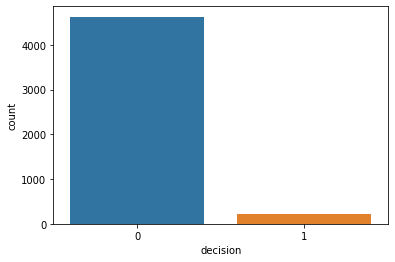

In [9]:
#class balance for rejects and accepts
ax = sns.countplot(x="decision",data=df_model)

In [10]:
#calculate rank of affiliation based on acceptances

#get list of institutions, rank by largest
affliations=aff_accept['affiliations'].explode().str.lower()
print(len(affliations.unique()))

df_aff=affliations.value_counts().reset_index()
df_aff.columns = ['institute', 'counts']

#drop gmail
df_aff=df_aff[df_aff.institute !='gmail.com']

#btain ranking of institute
df_aff['rank']=df_aff['counts'].rank(method='max', ascending=True)
df_aff.head()

#map domain to ranking and chnage values
ranks=df_aff.to_dict('records')
affliations_paper=df_model['affiliations'].tolist()


207


In [39]:
all_aff=df_model['affiliations'].explode().str.lower().value_counts()
all_aff.to_csv('aff.csv')

C:\Users\jaina\Anaconda3\envs\si670\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [40]:
all_aff=aff_accept['affiliations'].explode().str.lower().value_counts()
all_aff.to_csv('aff_accept.csv')

C:\Users\jaina\Anaconda3\envs\si670\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [34]:
aff

,institute,counts,rank
0,google.com,181,206.0
2,cs.cmu.edu,26,205.0
3,mit.edu,23,204.0
4,microsoft.com,23,204.0
5,berkeley.edu,23,204.0
...,...,...,...
202,geirhos.de,1,87.0
203,scs.ryerson.ca,1,87.0
204,vinai.io,1,87.0
205,student.unimelb.edu.au,1,87.0


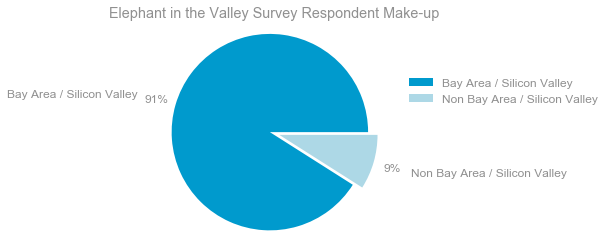

In [36]:
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']

fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12
labels = ['Bay Area / Silicon Valley', 
         'Non Bay Area / Silicon Valley']
percentages = [91, 9]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Author Affiliations")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))

In [13]:
len(all_ranks)

4842

In [12]:
#get affiliation ranking for each paper
all_ranks=[]
for paper in affliations_paper:
    rank_val=0
    for domain in paper:
        rank=next((item['rank'] for item in ranks if item["institute"] == domain), 0)
        rank_val+=rank
    rank_avg=rank_val/len(paper)
    all_ranks.append(rank_avg)

# add to dataframe 
df_model['affiliation_ranks']=all_ranks

In [14]:
#create dummy variables for the review type 
df_model=pd.get_dummies(df_model, columns=['type_review'])

In [26]:
df_model.head()

,dec,pub_counts_yr_adj,citation_counts_yr_adj,est_citation_counts_yr_adj,num_authors,dec_sen_score,review_sen_score,affiliations,avg_pub,avg_cite,avg_est_cite,max_pub,max_cite,max_est_cite,decision,affiliation_ranks,type_review_double_blind,type_review_single_blind
0,Accept (Poster),"[24, 5, 22, 2, 63, 120, 109]","[58, 5, 62, 2, 333, 446, 1379]","[387, 158, 555, 76, 942, 12832, 4186]",7.0,0.123275,0.161820,"[gmail.com, cs.cmu.edu, gmail.com, gmail.com, ...",49.285714,326.428571,2733.714286,120,1379,12832,0,70.857143,0,1
1,Accept (Poster),"[54, 56, 54]","[128, 158, 98]","[3882, 1848, 2663]",3.0,0.529200,0.127357,"[cs.princeton.edu, cs.princeton.edu, cs.prince...",54.666667,128.000000,2797.666667,56,158,3882,0,0.000000,0,1
2,Accept (Poster),"[10, 65]","[10, 147]","[555, 3075]",2.0,0.000000,0.173518,"[ttic.edu, ttic.edu]",37.500000,78.500000,1815.000000,65,147,3075,0,87.000000,0,1
3,Reject,"[12, 1, 50, 224, 157, 15, 6, 1, 29, 8, 2, 3, 1...","[22, 1, 128, 2054, 913, 35, 8, 1, 63, 8, 2, 3,...","[364, 322, 1799, 36634, 11432, 644, 407, 322, ...",15.0,0.100625,0.185682,"[microsoft.com, microsoft.com, microsoft.com, ...",34.266667,216.266667,3703.333333,224,2054,36634,0,204.000000,0,1
4,Reject,"[4, 10, 59]","[4, 12, 227]","[175, 626, 7272]",3.0,0.069817,0.149944,"[uva.nl, esat.kuleuven.be, uva.nl]",24.333333,81.000000,2691.000000,59,227,7272,0,117.333333,0,1


> ### EDA

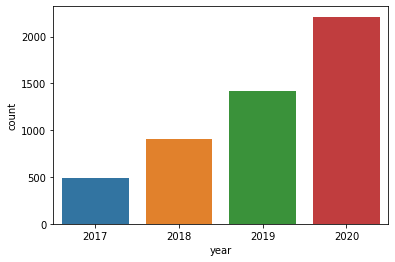

In [16]:
ax = sns.countplot(x="year",data=df_all)

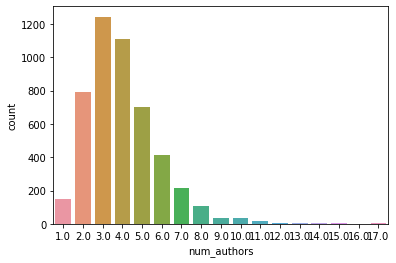

In [17]:
#number of submissions over the years
ax = sns.countplot(x="num_authors",data=df_model)

In [ ]:
sns.boxplot(x="cols", y="vals", data=df_plot,whis="range", palette="vlag")

### Baseline model

In [78]:
import statsmodels.formula.api as smf

> just predcting on the class balance 

In [99]:
model = smf.logit (formula='decision ~ type_review_single_blind ', data=df_model).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.182044
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               decision   No. Observations:                 4842
Model:                          Logit   Df Residuals:                     4840
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:                0.001552
Time:                        14:00:54   Log-Likelihood:                -881.46
converged:                       True   LL-Null:                       -882.83
Covariance Type:            nonrobust   LLR p-value:                   0.09790
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -3.0280      0.072    -41.927      0.000      -3.170      -2.886
type_review_single_blind    -0.4251      0.272     -1.563      0.118      -0.958       0.108
============================================================================================
"""

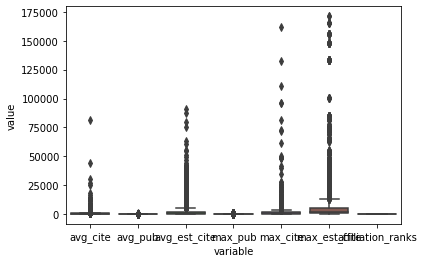

In [23]:
sns.boxplot(x="variable", y="value", data=pd.melt(df_model[['avg_cite','avg_pub','avg_est_cite','max_pub','max_cite','max_est_cite','affiliation_ranks']]))

In [25]:
df_model.corr()

,num_authors,dec_sen_score,review_sen_score,avg_pub,avg_cite,avg_est_cite,max_pub,max_cite,max_est_cite,decision,affiliation_ranks,type_review_double_blind,type_review_single_blind
num_authors,1.000000,0.049518,0.109469,0.094573,0.011788,0.097346,0.282442,0.094977,0.209019,0.054408,0.161669,0.049567,-0.049567
dec_sen_score,0.049518,1.000000,0.286015,0.079480,-0.014171,0.079733,0.061597,-0.019965,0.075133,0.151425,0.130645,-0.060261,0.060261
review_sen_score,0.109469,0.286015,1.000000,0.047348,-0.032096,0.092094,0.048042,-0.028183,0.087090,0.138698,0.127955,-0.166415,0.166415
avg_pub,0.094573,0.079480,0.047348,1.000000,0.596432,0.468815,0.888954,0.592131,0.412391,0.020508,0.143562,-0.020612,0.020612
avg_cite,0.011788,-0.014171,-0.032096,0.596432,1.000000,0.120343,0.545918,0.927014,0.079115,-0.005862,-0.010715,0.049469,-0.049469
avg_est_cite,0.097346,0.079733,0.092094,0.468815,0.120343,1.000000,0.459366,0.111226,0.908461,0.007201,0.139456,-0.204889,0.204889
max_pub,0.282442,0.061597,0.048042,0.888954,0.545918,0.459366,1.000000,0.644730,0.510567,0.011510,0.106750,0.016081,-0.016081
max_cite,0.094977,-0.019965,-0.028183,0.592131,0.927014,0.111226,0.644730,1.000000,0.105512,-0.007476,-0.010164,0.057796,-0.057796
max_est_cite,0.209019,0.075133,0.087090,0.412391,0.079115,0.908461,0.510567,0.105512,1.000000,0.007164,0.110065,-0.159198,0.159198
decision,0.054408,0.151425,0.138698,0.020508,-0.005862,0.007201,0.011510,-0.007476,0.007164,1.000000,0.167155,0.022623,-0.022623


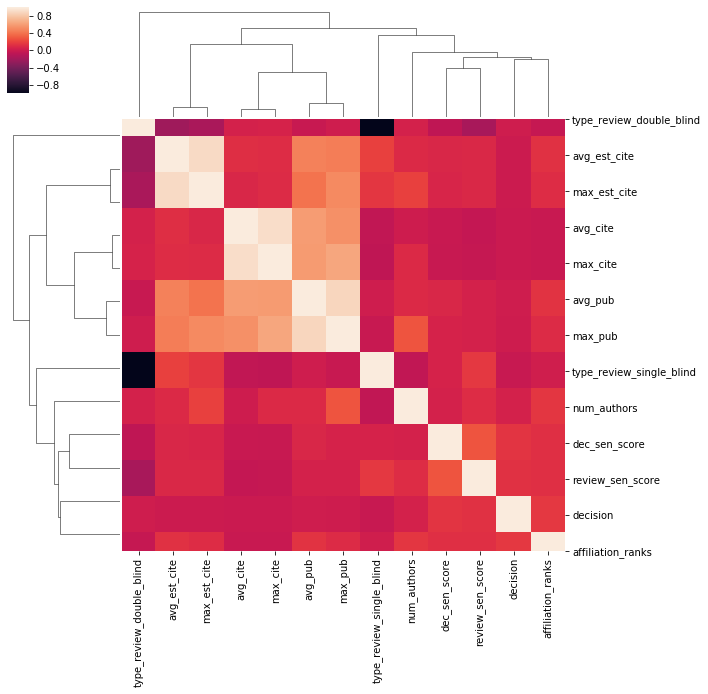

In [24]:
sns.clustermap(df_model.corr())

### Models with different measures of prestige 

In [95]:
measures=['avg_cite','avg_pub','avg_est_cite','max_pub','max_cite','max_est_cite','affiliation_ranks']

In [96]:
for m in measures:
    formula='decision ~ '+str(m)+' + type_review_single_blind + '+str(m)+'*type_review_single_blind'
    print('\n \n *******************************************'+str(m)+'***************************************')
    model = smf.logit (formula=formula, data=df_model).fit()
    print(model.summary())
    print(model.conf_int())


 
 *******************************************avg_cite***************************************
Optimization terminated successfully.
         Current function value: 0.181446
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               decision   No. Observations:                 4842
Model:                          Logit   Df Residuals:                     4838
Method:                           MLE   Df Model:                            3
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:                0.004829
Time:                        12:38:52   Log-Likelihood:                -878.56
converged:                       True   LL-Null:                       -882.83
Covariance Type:            nonrobust   LLR p-value:                   0.03630
                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------